# Acceleration Data Exploration

In [1]:
import numpy as np
import dataloader_halogaland.dataloader as dl
import matplotlib.pyplot as plt
import os
import scipy
from scipy import signal
import datetime

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

loader = dl.TDMS_dataloader(os.getcwd()+'/../Data/Halogaland_2022_04_22')
file = loader.read_file(loader.anodes[4])


In [3]:
acc = loader.load_acceleration(loader.acc_names[4], file)
print(file['acceleration_data'].channels())
print(file['acceleration_data']['A07-1y'].properties)

[<TdmsChannel with path /'acceleration_data'/'timestamp'>, <TdmsChannel with path /'acceleration_data'/'A07-1x'>, <TdmsChannel with path /'acceleration_data'/'A07-1y'>, <TdmsChannel with path /'acceleration_data'/'A07-1z'>, <TdmsChannel with path /'acceleration_data'/'A07-2x'>, <TdmsChannel with path /'acceleration_data'/'A07-2y'>, <TdmsChannel with path /'acceleration_data'/'A07-2z'>, <TdmsChannel with path /'acceleration_data'/'acc06'>, <TdmsChannel with path /'acceleration_data'/'acc07'>]
OrderedDict([('name', 'A07-1y'), ('description', 'y-dir of Geosig AC-73 force balance 3-axis accelerometer, SN: 58086. Mounted inside the bridge girder.'), ('position', '(0.0, 7.7, 44.2)'), ('orientation', '(0, 1, 0)'), ('conversion_factor', '1.249'), ('unit_string', 'volt')])


In [13]:
print(len(acc['1y']))

1843200


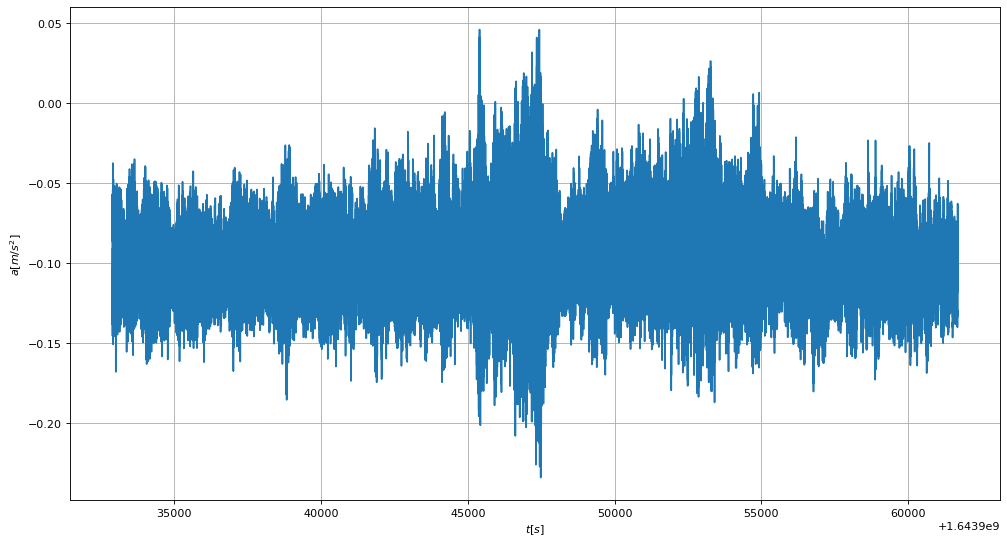

In [14]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(acc['timestamp'], acc['1y'])
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.show()

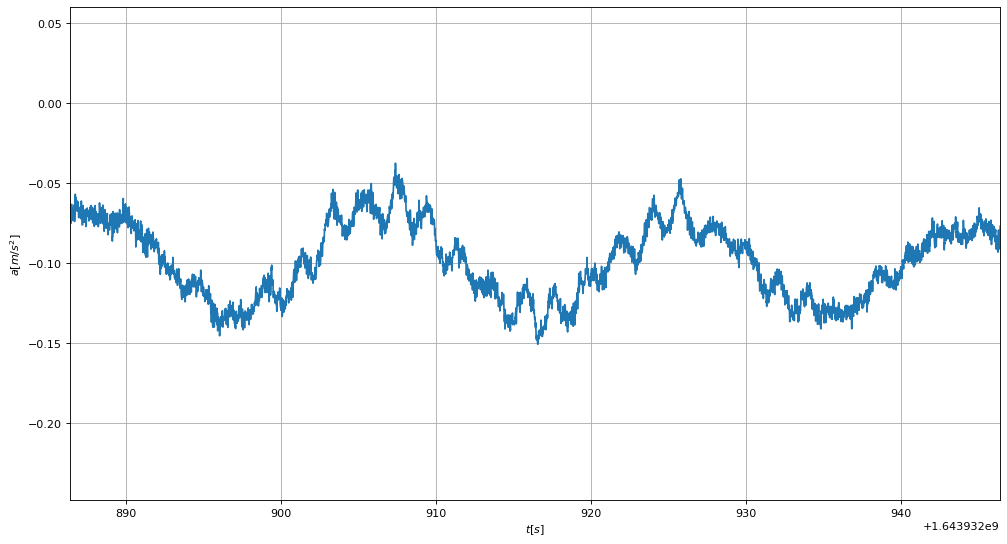

In [15]:
min = 1
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(acc['timestamp'], acc['1y'])
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.xlim([acc['timestamp'][0], acc['timestamp'][64*60*min]])
plt.show()

### Fourier transform to investigate the frequncy content

In [16]:
print(acc['timestamp'].shape[0])

1843200


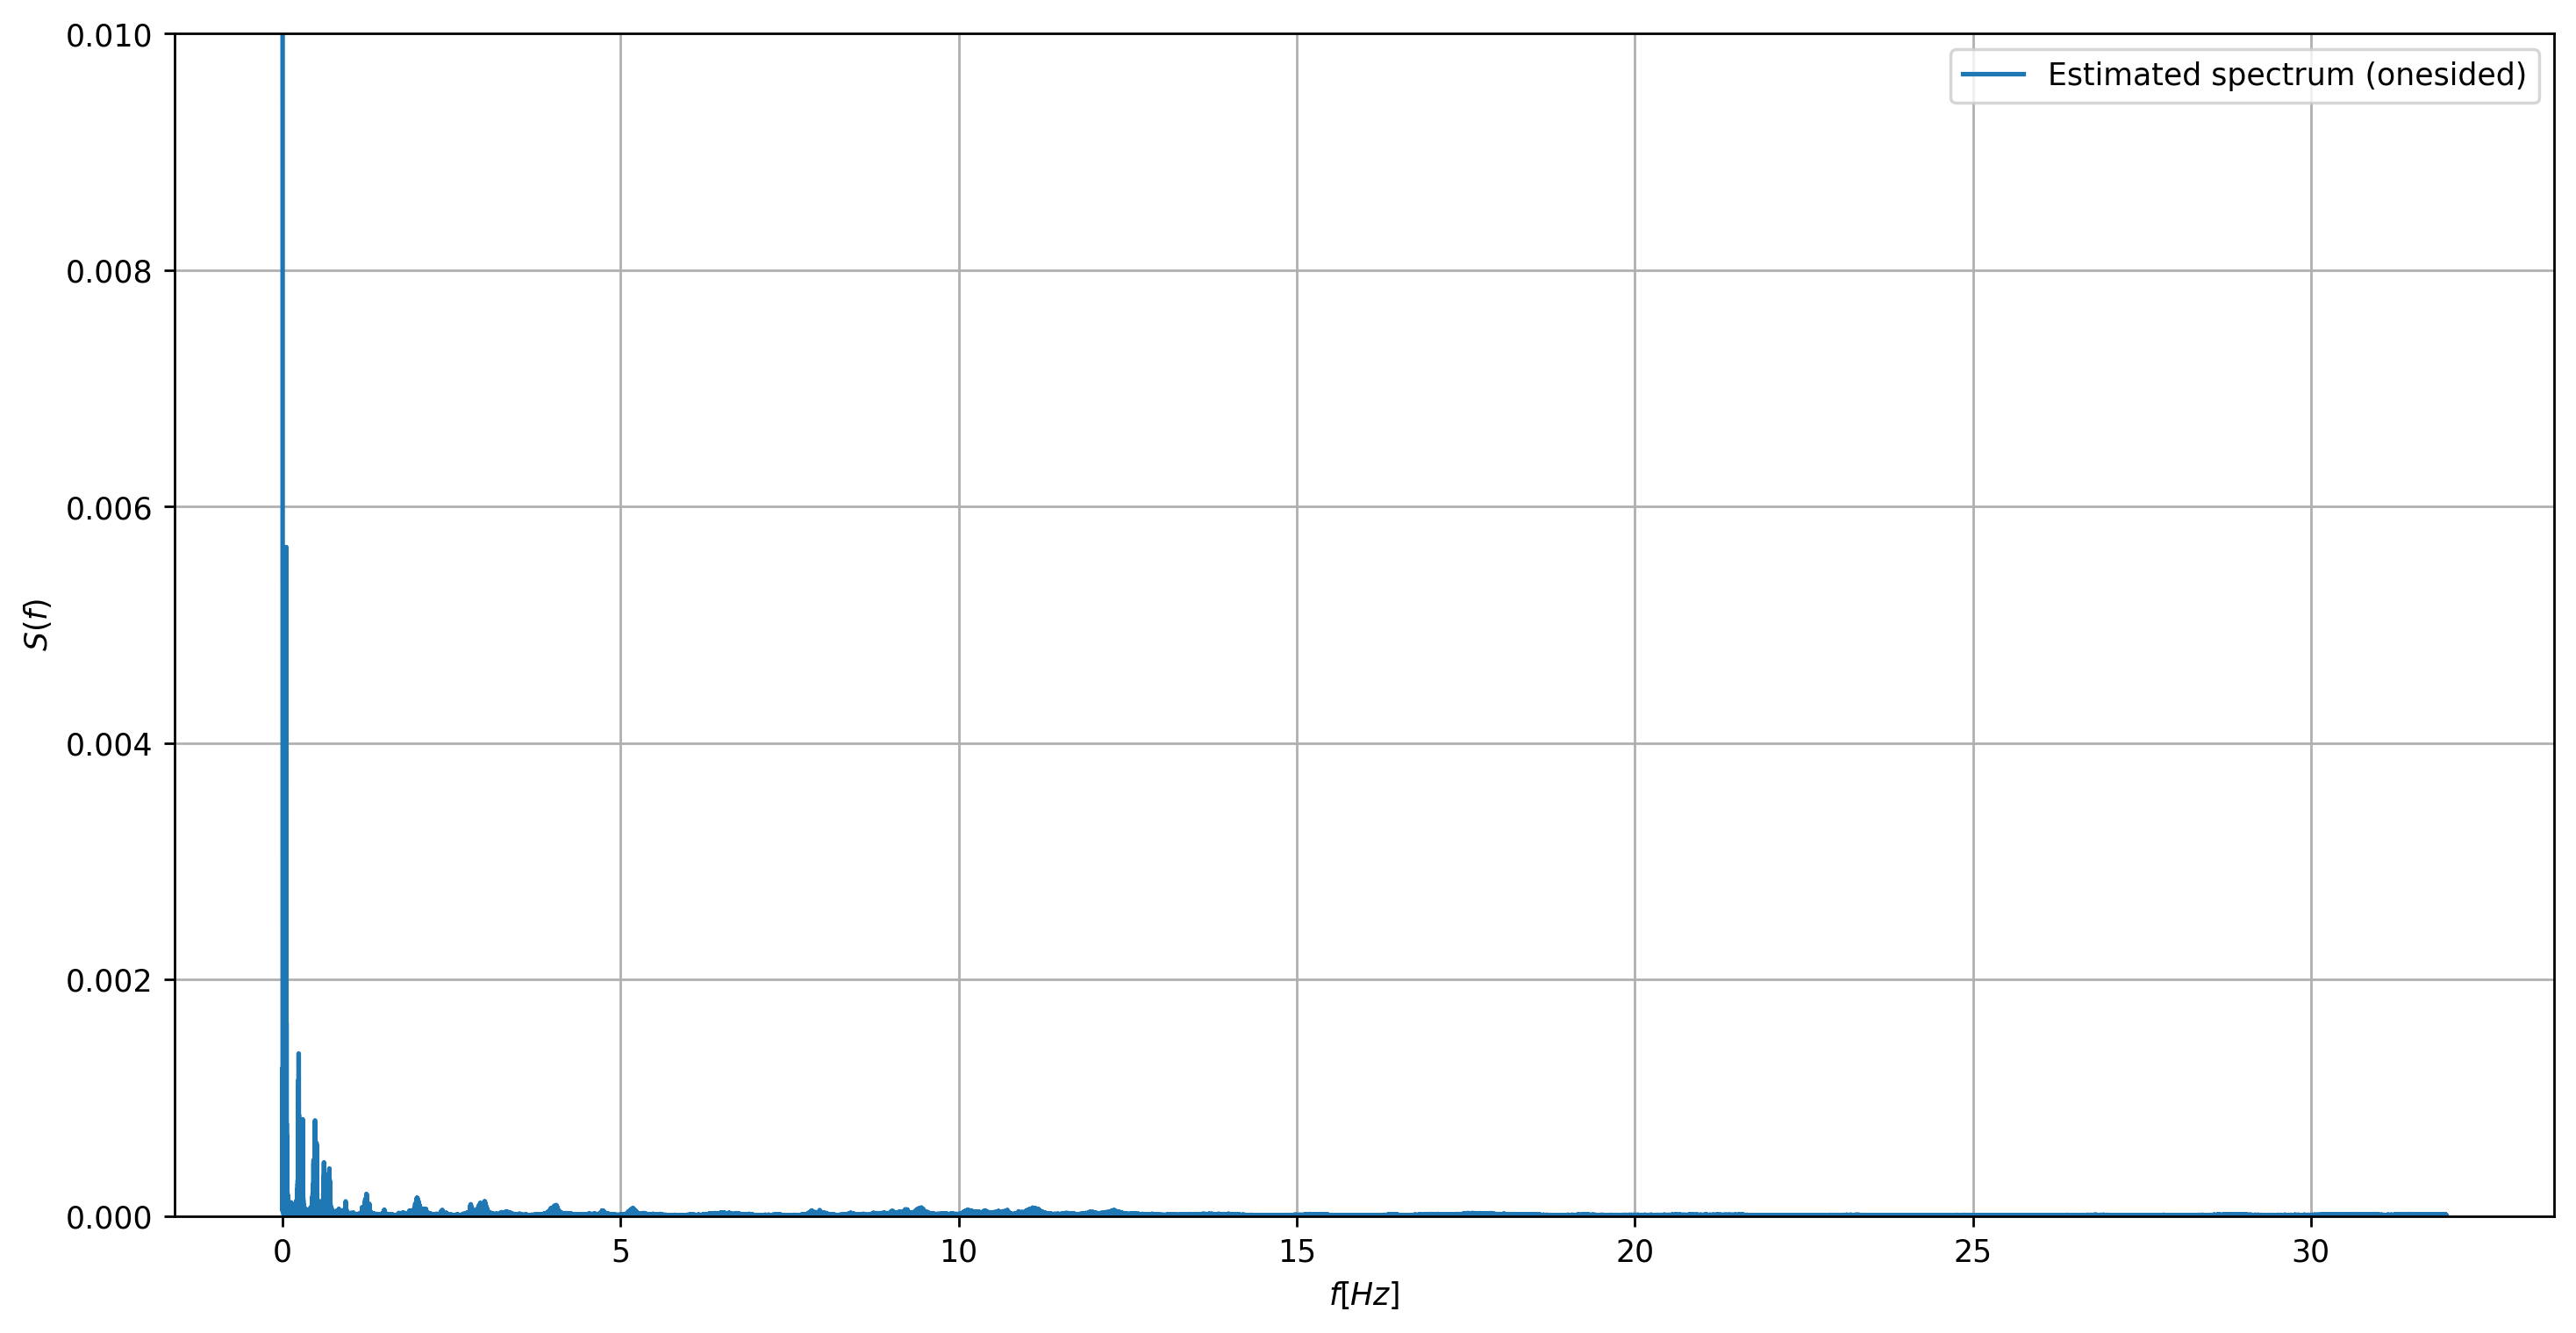

In [17]:
dt=acc['timestamp'][1]-acc['timestamp'][0] # Time step
"""
Xfft = np.fft.fft(acc['1y'])/acc['timestamp'].shape[-1]
Sx_est = np.fft.fftshift(Xfft) # This shifts the DFT negative f, mean, positive f: [-w 0 w]
f_est = np.linspace(-1/2/dt,1/2/dt,acc['timestamp'].shape[0]); # Frequency axis in Hz
"""



Sx_est = (2.0/len(acc['1y']))*np.fft.rfft(acc['1y'])
f_est = np.fft.rfftfreq(acc['1y'].shape[0],dt)

plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f_est, np.abs(Sx_est) ,label = 'Estimated spectrum (onesided)')
plt.xlabel('$f [Hz]$')
plt.ylabel('$S(f)$')
plt.ylim([0, 0.01])
#plt.xlim([0, 5])
plt.grid()
plt.legend()

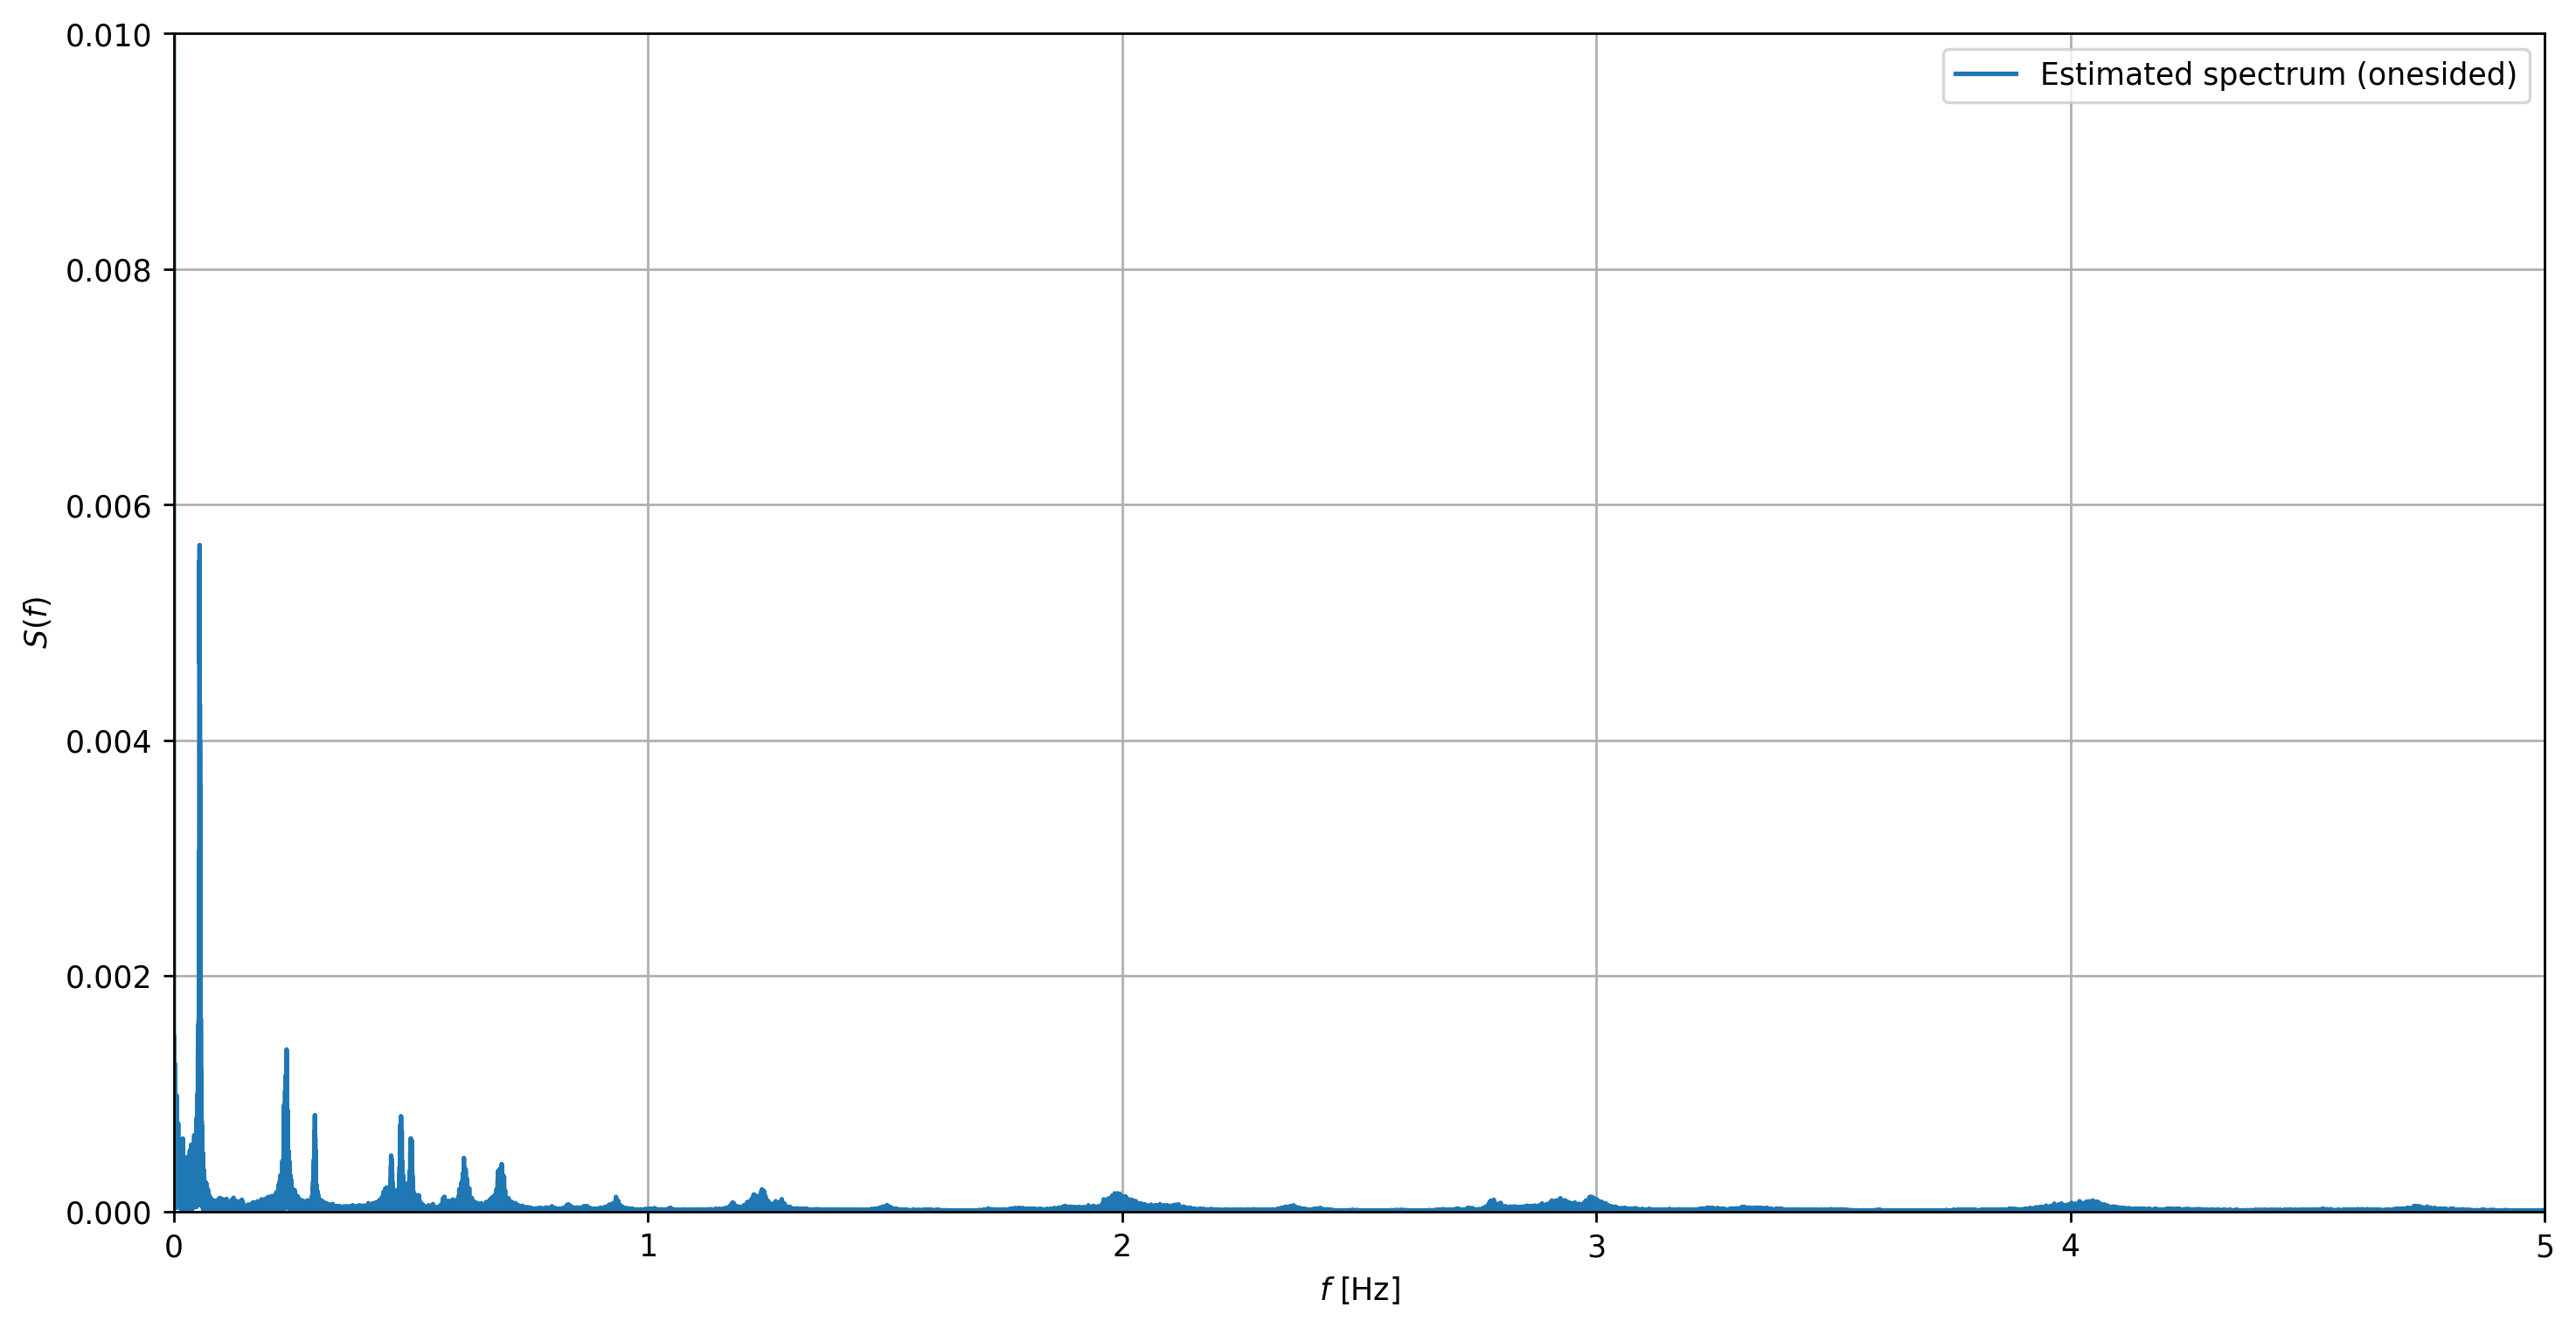

In [18]:
plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f_est, np.abs(Sx_est) ,label = 'Estimated spectrum (onesided)')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')
plt.ylim([0, 0.01])
plt.xlim([0, 5])
plt.grid()
plt.legend()

### Acceleration spectrum from Welch's method

64.0
16385


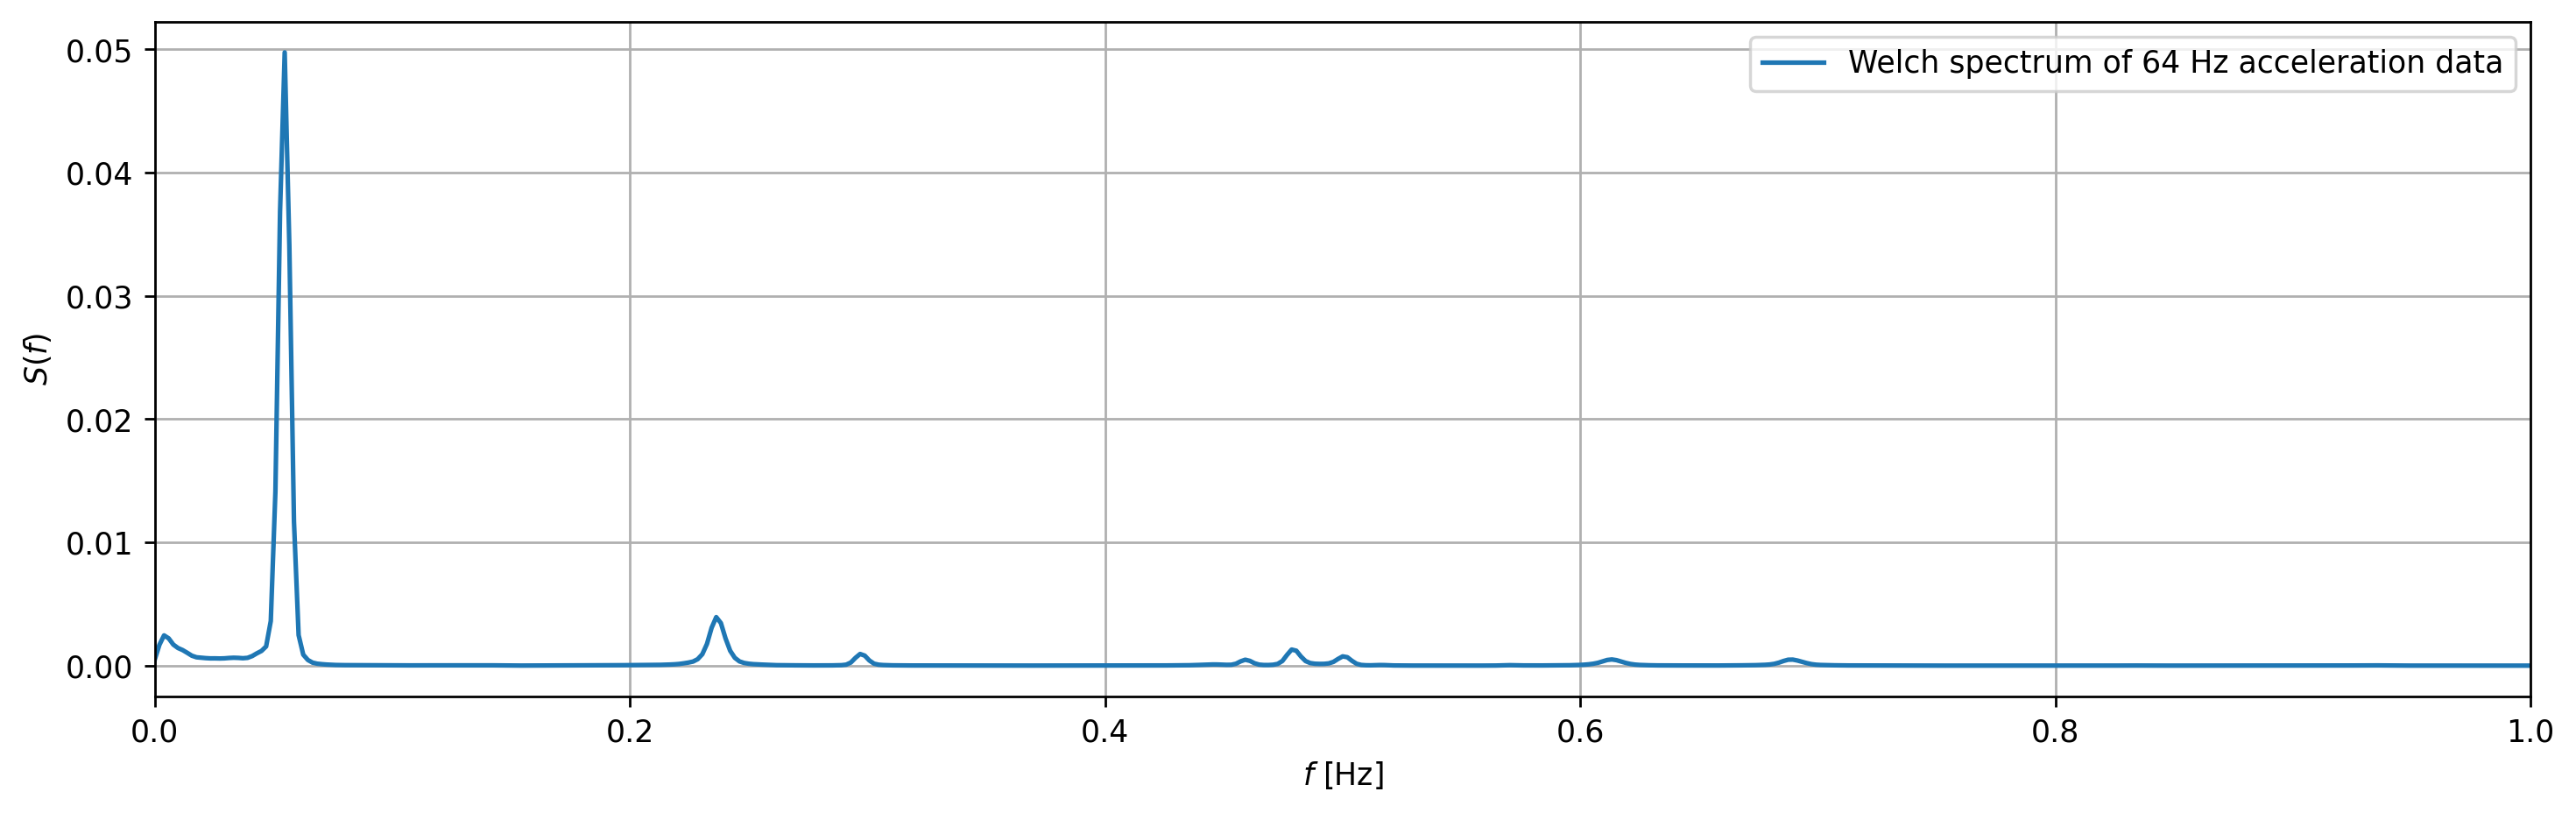

In [22]:
Ndivisions=100 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(acc['timestamp'])/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding
dt=acc['timestamp'][1]-acc['timestamp'][0] # Time step
print(1/dt)

# Call welch from scipy signal processing
f, Sx_welch=signal.welch(acc['1y'], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

print(len(f))
plt.figure(figsize=(14,4), dpi= 250)
plt.plot(f,Sx_welch,label = 'Welch spectrum of 64 Hz acceleration data')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')#
plt.xlim([0,1])
#plt.yscale('log')
plt.grid()
plt.legend()
plt.savefig("welch_acceleration_freq_0-5_Hz.jpg")

### Constructing the auto correlation function

0.015625
64.0
0.015625
32768


/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


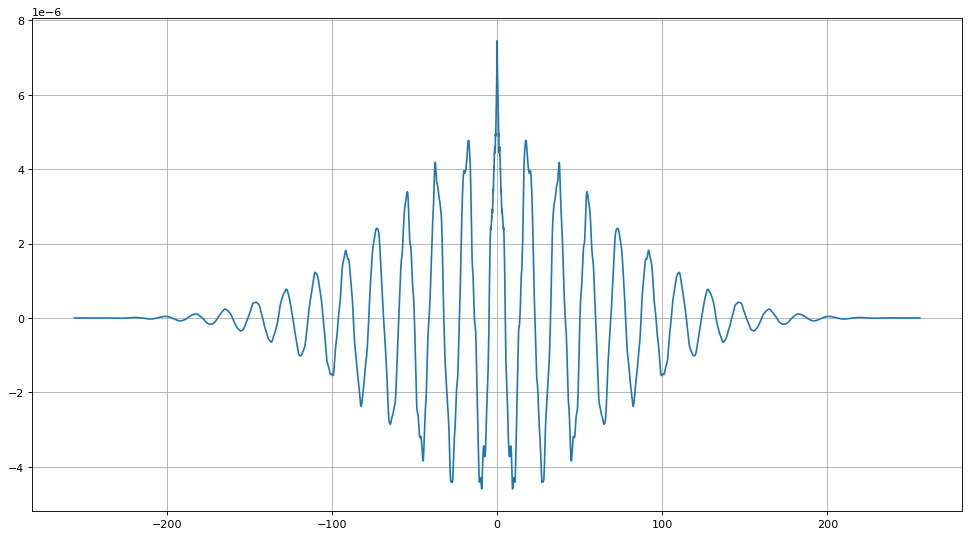

In [20]:
fi, Sx_welch=signal.welch(acc['1y'], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=False, scaling='density', axis=- 1, average='mean')
print(dt)
print(1/dt)
var = np.var(acc['1y'])
acorr = np.fft.ifft(Sx_welch) #/var/len(acc['1y'])
acorr = np.fft.fftshift(acorr)
time_lag = np.arange(0,len(acorr))*dt
time_lag = time_lag - np.average(time_lag)
print(time_lag[-1]-time_lag[-2])

#acorr = acorr[time_lag>0]
#time_lag = time_lag[time_lag>0]

print(len(time_lag))

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
#plt.xlim([0, 50])


(0.0, 50.0)

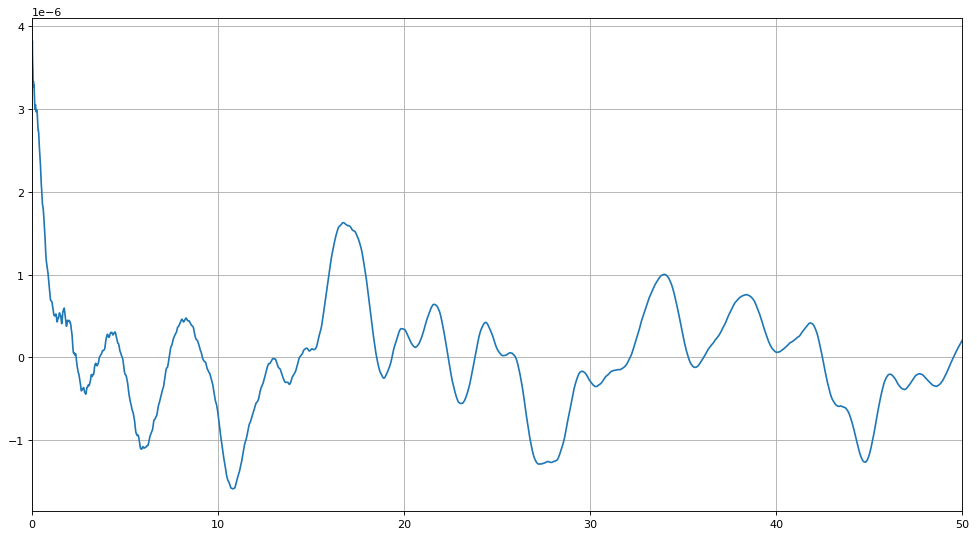

In [11]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
plt.xlim([0, 50])

### Applying a Butterworth filter as a lowpass filter

64.0


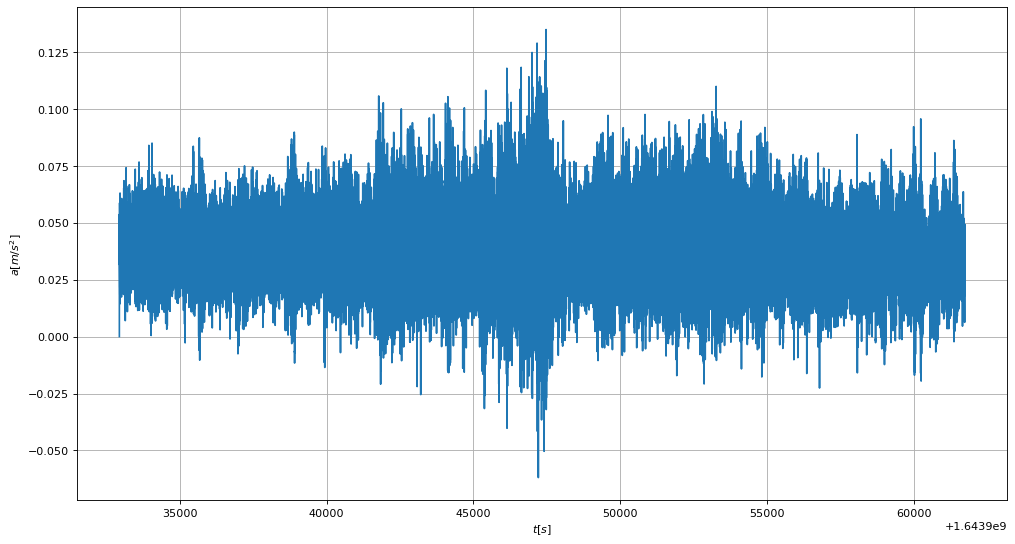

In [12]:
filter_order = 6
sampling_frequency = 1/dt
cutoff_frequency = 2


print(sampling_frequency)

sos = signal.butter(filter_order,cutoff_frequency,"low", fs=sampling_frequency, output='sos')

filtered_acc = signal.sosfilt(sos, acc['1y'])

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(acc['timestamp'], filtered_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.show()

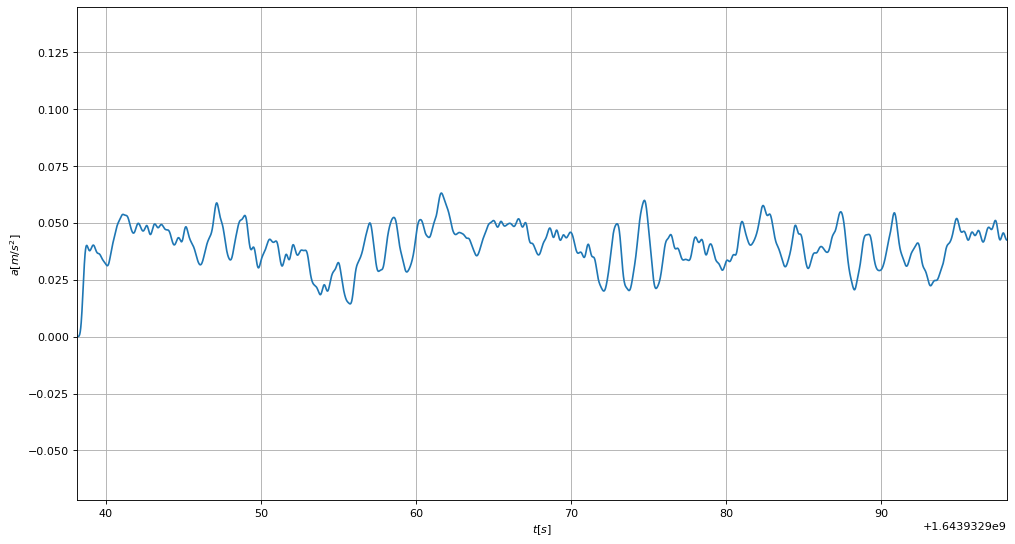

In [13]:
min = 1
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(acc['timestamp'], filtered_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.xlim([acc['timestamp'][0], acc['timestamp'][64*60*min]])
plt.show()

16385


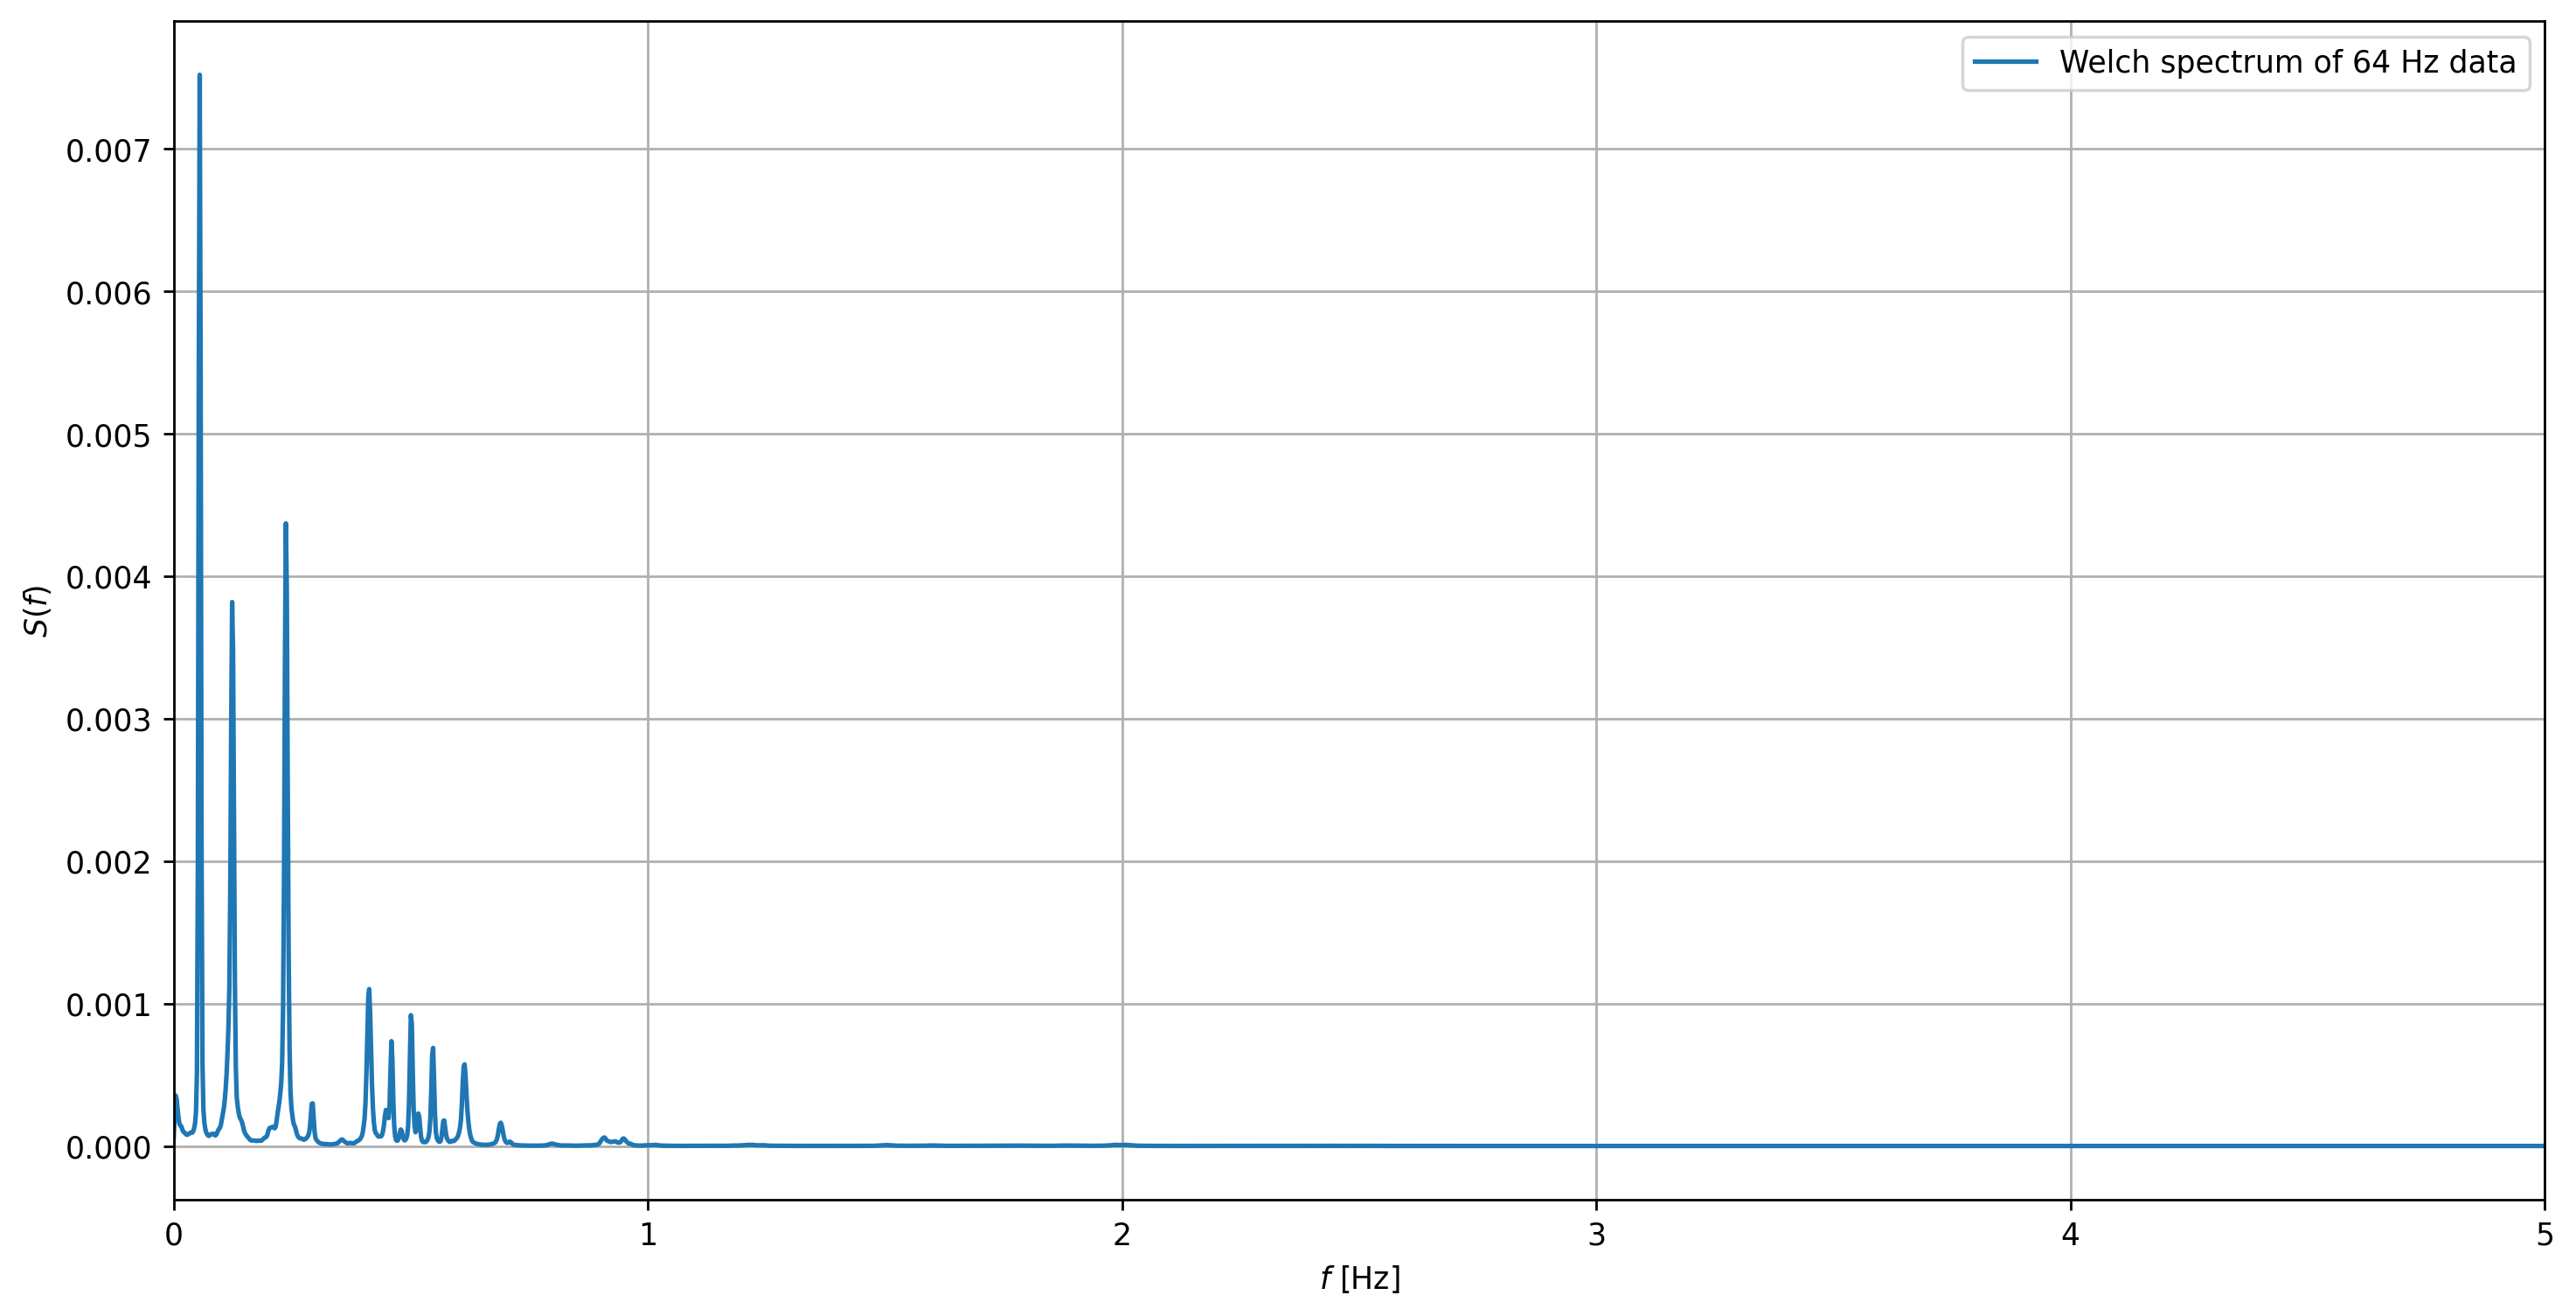

In [14]:
Ndivisions=100 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(acc['timestamp'])/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding
dt=acc['timestamp'][1]-acc['timestamp'][0] # Time step

# Call welch from scipy signal processing
f, Sx_welch=signal.welch(filtered_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

print(len(f))
# Plot and compare with exact solution
plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f,Sx_welch,label = 'Welch spectrum of 64 Hz data')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')
#plt.yscale('symlog')
plt.xlim([0,5])
plt.grid()
plt.legend()
plt.savefig("welch_acceleration_freq_0-5_Hz.jpg")

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


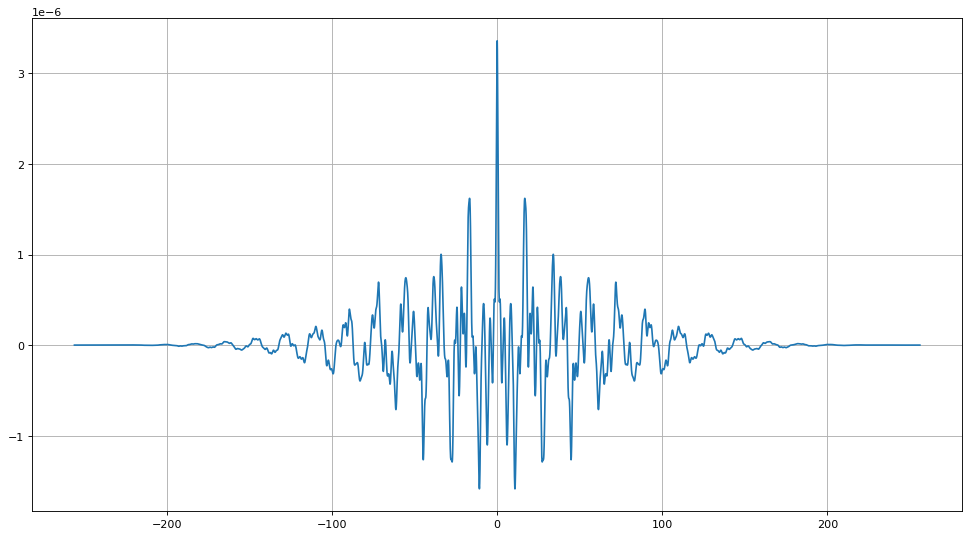

In [15]:
fi, Sx_welch=signal.welch(filtered_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=False, scaling='density', axis=- 1, average='mean')

var = np.var(filtered_acc)
acorr_filtered = np.fft.ifft(Sx_welch)
acorr_filtered = np.fft.fftshift(acorr_filtered)
time_lag = np.arange(0,len(acorr))*dt
time_lag = time_lag - np.average(time_lag)

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr_filtered))
plt.grid()
#plt.xlim([0, 50])

(0.0, 50.0)

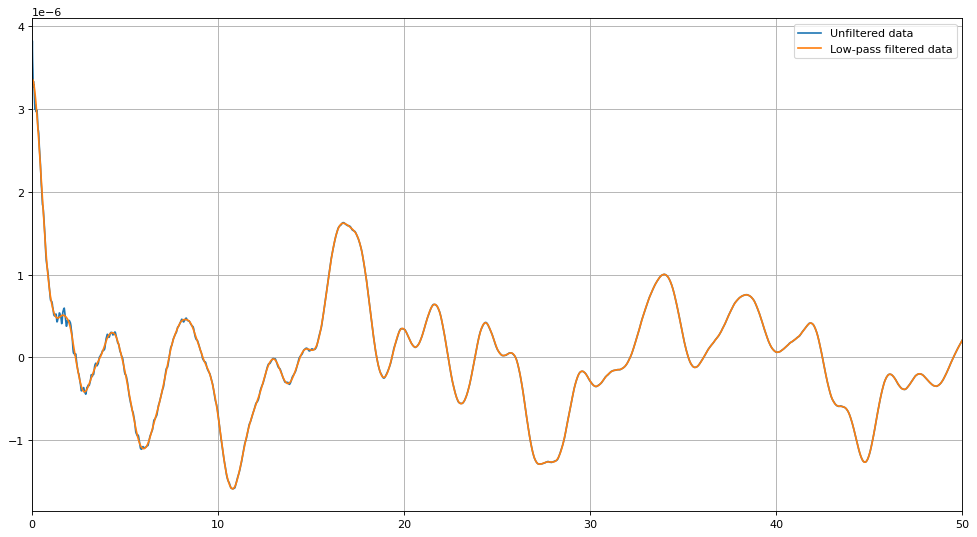

In [16]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr), label = 'Unfiltered data')
plt.plot(time_lag, (acorr_filtered), label = 'Low-pass filtered data')
plt.legend()
plt.grid()
plt.xlim([0, 50])

### Downsampling

In [17]:
x = np.linspace(0,10)
#print((x))

sampling_frequency_new = 4
factor = int(sampling_frequency/sampling_frequency_new)
print("Downsampling factor: " + str(factor))

down_sampled_acc = filtered_acc[::factor]
down_sampled_time = acc['timestamp'][::factor]


Downsampling factor: 16


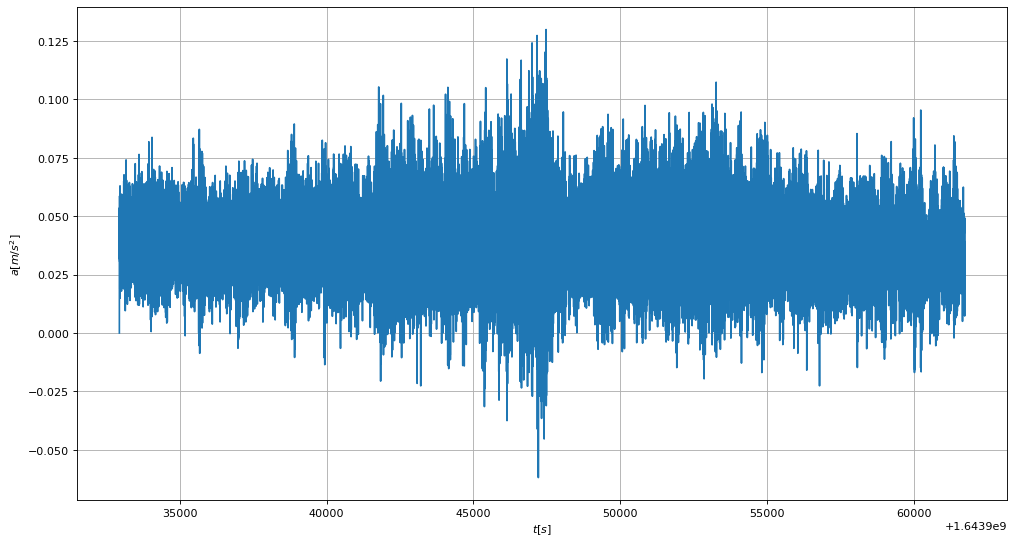

In [18]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(down_sampled_time, down_sampled_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.show()

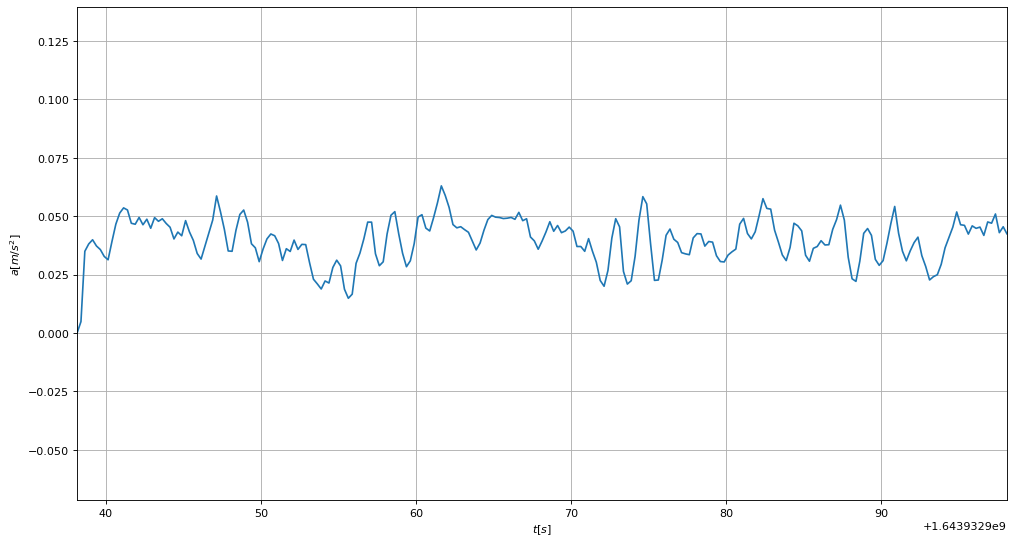

In [19]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(down_sampled_time, down_sampled_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.xlim([down_sampled_time[0], down_sampled_time[sampling_frequency_new*60*min]])
plt.show()

4
1025


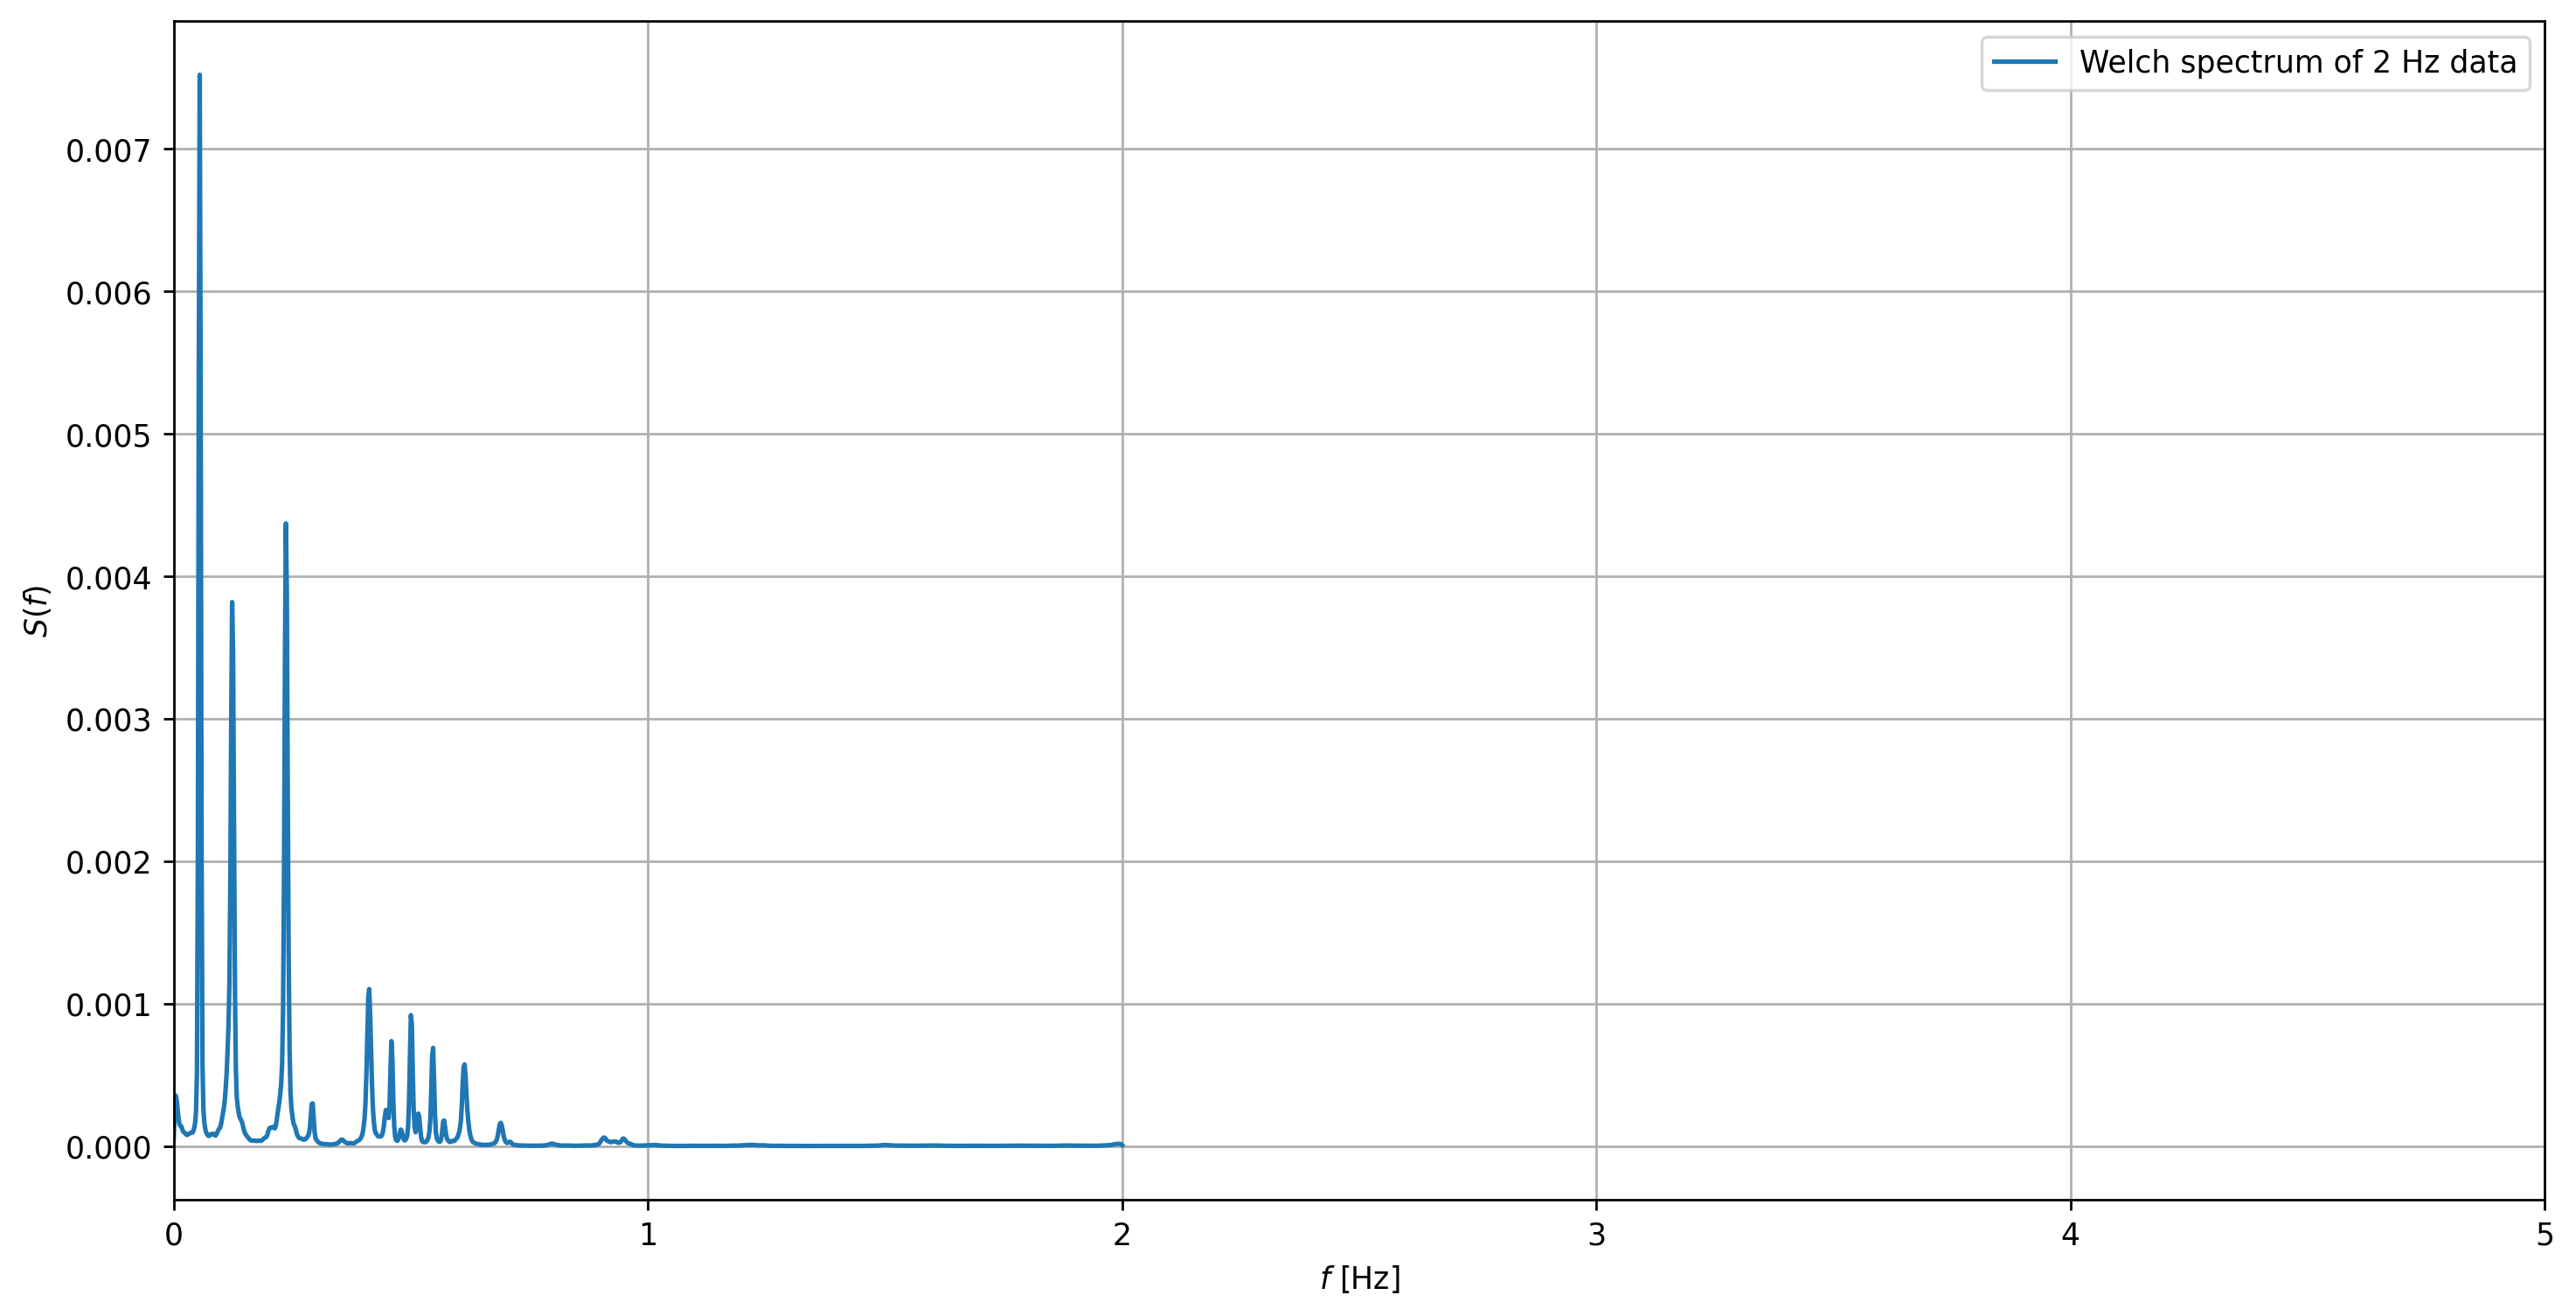

In [20]:
Ndivisions=100 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(down_sampled_acc)/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding
dt=down_sampled_time[1]-down_sampled_time[0] # Time step
print(int(1/dt))

# Call welch from scipy signal processing
f, Sx_welch=signal.welch(down_sampled_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

print(len(f))
# Plot and compare with exact solution
plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f,Sx_welch,label = 'Welch spectrum of 2 Hz data')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')
#plt.yscale('symlog')
plt.xlim([0,5])
plt.grid()
plt.legend()

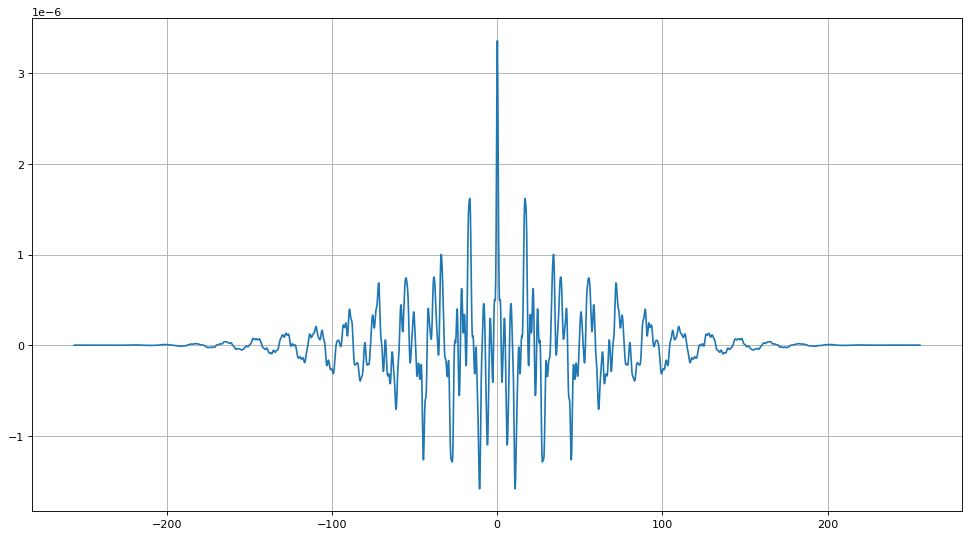

In [21]:
fi, Sx_welch=signal.welch(down_sampled_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=False, scaling='density', axis=- 1, average='mean')

var = np.var(down_sampled_acc)
acorr_down = np.fft.ifft(Sx_welch)
acorr_down = np.fft.fftshift(acorr_down)/factor
time_lag_down = np.arange(0,len(acorr_down))*dt
time_lag_down = time_lag_down - np.average(time_lag_down)

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag_down, (acorr_down))
plt.grid()
#plt.xlim([0, 50])

(0.0, 50.0)

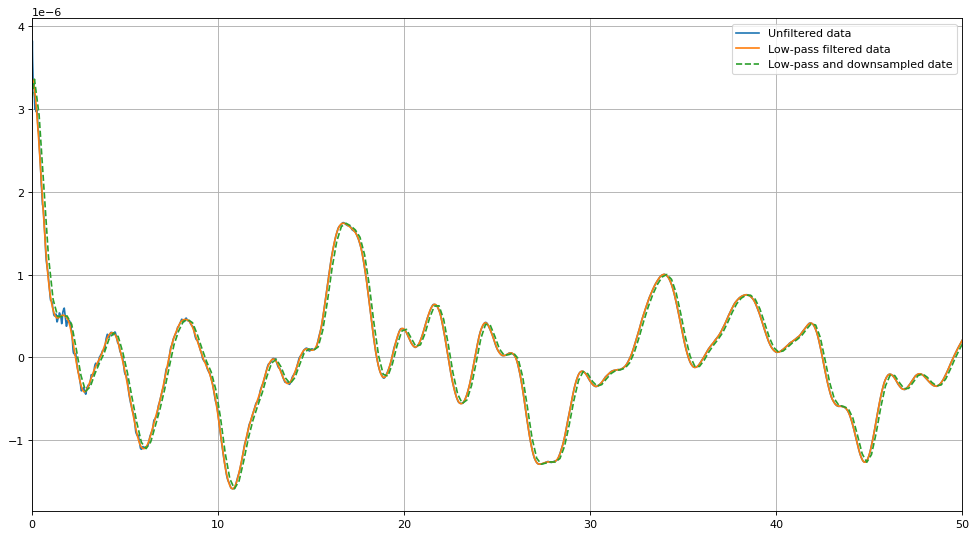

In [22]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr), label = 'Unfiltered data')
plt.plot(time_lag, (acorr_filtered), label = 'Low-pass filtered data')
plt.plot(time_lag_down, (acorr_down),  '--', label = 'Low-pass and downsampled date')
plt.legend()
plt.grid()
plt.xlim([0, 50])

In [25]:
print(len(down_sampled_time))
print(len(down_sampled_acc)/7200)

115200
16.0


In [24]:
print(down_sampled_time[1]-down_sampled_time[0])

0.2499988079071045


In [26]:
print(down_sampled_acc.shape)

(115200,)


In [36]:
acc_intervals = np.reshape(down_sampled_acc, (-1,7200))
time_intervals = np.reshape(down_sampled_time, (-1,7200))

In [43]:
print(acc_intervals.shape[0])
print((acc_intervals[0]))

16
[1.20235090e-08 4.88448678e-03 3.49884874e-02 ... 4.74548366e-02
 4.90776405e-02 4.27902084e-02]


In [41]:
import koma.oma, koma.plot

i = 100
s = 3

orders = np.arange(2, 50+2, 2)
print(orders)
stabcrit = {'freq':0.2, 'damping': 0.2, 'mac': 0.3}

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48
 50]


In [44]:
freq_modes = []

for j in range(acc_intervals.shape[0]):

    #Cov-SSI call
    lambd, phi = koma.oma.covssi(acc_intervals[j].transpose(), time_intervals[j].transpose(), i, orders, showinfo=False) # find poles by Cov-SSI
    lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac') # Stable poles

    #Pole clustering
    pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
    prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
    args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

    xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

    #plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

    xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
    fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

    xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
    fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

    freq_modes.append([freq for freq in fn_mean])

IndexError: tuple index out of range